# **Analyzing Geospatial Data using different NLP Techniques (IMDb Summary Dataset - Countries)**

### The listed libraries and modules are essential tools for data analysis, visualization, natural language processing, and machine learning, enabling efficient handling, processing, and interpretation of textual and numerical data.

1. **pandas** (`pd`): For data manipulation and analysis, working with DataFrames.
2. **re**: For regular expressions, useful in text pattern matching.
3. **nltk**: A Natural Language Processing (NLP) library for text preprocessing and analysis.
4. **torch**: PyTorch, a deep learning framework for working with neural networks.
5. **numpy** (`np`): For numerical computing and handling arrays.
6. **seaborn** (`sns`): For creating advanced statistical visualizations.
7. **matplotlib.pyplot** (`plt`): For generating plots and graphs.
8. **folium**: For creating interactive maps.
9. **ast**: For safely evaluating or converting Python literals.
10. **branca.colormap.linear**: For creating custom color maps in visualizations.
11. **nltk.corpus.stopwords**: Provides a collection of common stopwords for text filtering.
12. **nltk.tokenize.word_tokenize**: For tokenizing text into words.
13. **collections.Counter**: For counting occurrences of elements in an iterable.
14. **nltk.util.ngrams**: For generating n-grams (sequences of n items) from text.
15. **textblob**: For basic sentiment analysis and text processing.
16. **transformers**: For working with pre-trained language models like BERT.
17. **sklearn.metrics.pairwise.cosine_similarity**: For calculating the similarity between vectors.
18. **sklearn.cluster.KMeans**: For clustering data into groups.
19. **nltk.sentiment.SentimentIntensityAnalyzer**: For sentiment analysis using VADER.

In [1]:
import pandas as pd
import re
import nltk
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import ast
from branca.colormap import linear
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
df1 = pd.read_csv('/content/drive/MyDrive/Final Project /LATEST DATASET /final_summary_cleaned_geocoded (1).csv')

In [4]:
df1 = df1.drop(columns=['Unnamed: 0', 'city'])

## **Location Index Cleaning and Context Extraction**

**Purpose**:  
The code is designed to process location indices (start and end positions of location mentions) in text, clean invalid indices, and extract surrounding context (before and after the mention) using a specified window size.

**Approaches**:
1. **Safe String to List Conversion**: Converts string representations of lists/tuples in the `geo_indices` column into actual Python lists using `ast.literal_eval()` for safe evaluation.
2. **Recalculation of Indices**: The function `recalculate_indices` tokenizes the text and recalculates the positions of location tokens within the text to get accurate start and end indices.
3. **Context Extraction**: The `extract_contexts` function extracts context around location mentions, ensuring the indices are valid and within the bounds of the text.
4. **Index Validation and Cleaning**: The `clean_geo_indices` function ensures that the location indices are valid, removing any invalid or malformed indices from the data.


In [5]:
# Safely convert string representations of lists/tuples into actual lists/tuples
df1['geo_indices'] = df1['geo_indices'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
)

In [6]:
def recalculate_indices(original_text, location_tokens):
    tokens = word_tokenize(original_text)
    new_indices = []
    for loc in location_tokens:
        if loc in tokens:
            start = tokens.index(loc)
            end = start + 1
            new_indices.append((start, end))
    return new_indices

In [7]:
def extract_contexts(text, geo_indices, window_size):
    tokens = word_tokenize(text)
    context_before = []
    context_after = []

    for start, end in geo_indices:
        # Validate indices
        if not (0 <= start < end <= len(tokens)):
            print(f"Skipping invalid index ({start}, {end}) for text: {text}")
            continue

        # Extract context
        window_start = max(0, start - window_size)
        window_end = min(len(tokens), end + window_size)
        context_before.append(" ".join(tokens[window_start:start]))
        context_after.append(" ".join(tokens[end:window_end]))

    return context_before, context_after

In [8]:
def clean_geo_indices(geo_indices):
    if isinstance(geo_indices, list):
        return [(start, end) for start, end in geo_indices if isinstance(start, int) and isinstance(end, int) and start < end]
    return []

df1['geo_indices'] = df1['geo_indices'].apply(clean_geo_indices)

## **Context Extraction for Location Mentions in Text**

**Purpose**:
The code extracts context (words before and after) for mentions of specific locations in text, based on given indices. This helps to capture relevant surrounding text for each location mentioned.

**Approaches**:
1. **Context Extraction**: Tokenizes the text and extracts a defined window of words (before and after the location) based on the provided indices.
2. **Window Size**: Uses a fixed window size (10 tokens) to extract the surrounding context for each location mention.
3. **Data Processing**: Filters out rows with no location indices and applies the context extraction function to each remaining row, creating "Context Before" and "Context After" columns in the dataset.

In [ ]:
nltk.download('punkt_tab')
def extract_contexts(text, geo_indices, window_size):
    tokens = word_tokenize(text)
    context_before = []
    context_after = []

    # Proceed only if geo_indices is not empty
    if not geo_indices:
        return context_before, context_after

    # For each location index range in geo_indices, extract context
    for start, end in geo_indices:
        if start < 0 or end <= 0 or start >= len(tokens) or end > len(tokens):
            continue
        window_start = max(0, start - window_size)
        window_end = min(len(tokens), end + window_size)
        context_before.append(" ".join(tokens[window_start:start]))
        context_after.append(" ".join(tokens[end:window_end]))

    return context_before, context_after

# Define window size
window_size = 10

# Filter rows where 'geo_indices' is not empty
df_non_empty_geo = df1[df1['geo_indices'].apply(lambda x: len(x) > 0)]

# Apply the extract_contexts function to each remaining row
df_non_empty_geo['Context Before'], df_non_empty_geo['Context After'] = zip(*df_non_empty_geo.apply(
    lambda row: extract_contexts(row['final_summary_No_Stopwords'], row['geo_indices'], window_size), axis=1
))

# Display relevant columns
print(df_non_empty_geo[['film_id', 'Context Before', 'Context After']])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


          film_id                                     Context Before  \
1       tt1142433                                                 []   
2      tt11426228  [halloween store opens deserted stripmall frie...   
4      tt11426562  [winter series notsowell known yet bloody, kno...   
6      tt11426660  [small town corsicana texas harddriving, small...   
9       tt1142977  [boys beloved dog passes, dog passes suddenly ...   
...           ...                                                ...   
22722  tt11394282                                                 []   
22726   tt1139780  [canada atmospheric condition allows teenage p...   
22731  tt11398152  [immersion rich landscapes sable island life z...   
22732  tt11398388  [riotsville fictional town built us military u...   
22733  tt11400008  [suffering fiasco hotel business eleanora good...   

                                           Context After  
1                                                     []  
2      [treating 

<ipython-input-9-b73063a1ee4c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty_geo['Context Before'], df_non_empty_geo['Context After'] = zip(*df_non_empty_geo.apply(
<ipython-input-9-b73063a1ee4c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty_geo['Context Before'], df_non_empty_geo['Context After'] = zip(*df_non_empty_geo.apply(


## **Word Frequency Analysis and Sentiment Evaluation for Locations**

**Purpose**:
The code analyzes text data associated with different locations (e.g., countries), calculating the frequency of meaningful words by removing stopwords. It also performs sentiment analysis to identify positive and negative words for each location.

**Approaches**:
1. **Word Frequency Calculation**: Tokenizes text data (from "Context Before" and "Context After" fields), removes stopwords, and counts meaningful word occurrences.
2. **Sentiment Analysis**: Uses the NLTK SentimentIntensityAnalyzer to evaluate the sentiment of the top words for each location.
3. **Data Processing**: Iterates through the dataset, calculates word frequencies, and analyzes sentiment, storing results in a dictionary for each location.

In [ ]:
dfgeo = pd.DataFrame(df_non_empty_geo)
nltk.download('stopwords')
# Function to calculate meaningful word frequency
def calculate_frequency(contexts):
    stop_words = set(stopwords.words('english'))

    all_words = []
    for context in contexts:
        words = word_tokenize(context)
        filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
        all_words.extend(filtered_words)

    word_freq = Counter(all_words)
    return word_freq

# Initialize a dictionary to hold the frequency counts for each location
location_frequencies = {}

# Loop over each row in the dataframe
for index, row in dfgeo.iterrows():
    country = row['country']
    contexts = row['Context Before'] + row['Context After']
    word_freq = calculate_frequency(contexts)
    location_frequencies[country] = dict(word_freq)

for country, word_freq in location_frequencies.items():
    print(f'"{country}" -> {word_freq}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


"United States" -> {}
" Brazil" -> {'agent': 8, 'sai': 4, 'srinivasa': 2, 'athreya': 87, 'authentic': 2, 'humorous': 1, 'investigative': 2, 'thriller': 2, 'revolving': 2, 'around': 5, 'adventures': 3, 'detective': 5, 'based': 6, 'nellore': 17, 'wakes': 3, 'middle': 2, 'learn': 3, 'mother': 3, 'mahalakshmis': 8, 'death': 4, 'leaves': 2, 'home': 2, 'college': 5, 'bhopal': 2, 'see': 2, 'mahalakshmi': 4, 'already': 3, 'cremated': 6, 'uncle': 4, 'years': 2, 'later': 15, 'name': 3, 'srinivas': 2, 'sets': 5, 'agency': 5, 'named': 2, 'fbi': 6, 'assistant': 2, 'helps': 2, 'cases': 5, 'mostly': 2, 'involved': 2, 'solving': 2, 'petty': 4, 'day': 10, 'writer': 2, 'friend': 1, 'sirish': 5, 'informs': 2, 'unidentified': 10, 'body': 22, 'venkatachalam': 7, 'goes': 5, 'arrogant': 2, 'ci': 2, 'gautham': 8, 'krishna': 2, 'arrests': 2, 'suspicion': 2, 'murderin': 2, 'prison': 4, 'meets': 3, 'acknowledges': 3, 'maruthi': 13, 'rao': 6, 'tells': 2, 'story': 2, 'daughter': 7, 'divya': 10, 'went': 4, 'ongole'

## **Sentiment Analysis and Word Frequency Calculation**

This code performs sentiment analysis on word frequencies collected from location-based contexts and outputs the top positive and negative words for each location.

1.  **Sentiment Analysis**:
   - **Sentiment Scores**: For each word, the code uses NLTK’s `SentimentIntensityAnalyzer` to obtain a sentiment score (a compound score ranging from -1 to +1).
   - **Sorting and Filtering**: Words are sorted based on their sentiment score. Positive words are those with a positive score, and negative words have a negative score.
   - The top N positive and negative words are identified.

2. **Data Preparation**:  Duplicates of the country names are removed from the dataframe `dfgeo` to ensure unique entries.

3. **Output**: the code outputs the top positive and negative words for each location along with their sentiment scores.


In [ ]:
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate meaningful word frequency
def calculate_frequency(contexts):
    stop_words = set(stopwords.words('english'))
    all_words = []

    for context in contexts:
        # Tokenize the context into words
        words = word_tokenize(context)
        # Filter out stop words and non-alphabetic words
        filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
        all_words.extend(filtered_words)

    # Count the frequency of each word
    word_freq = Counter(all_words)
    return word_freq

# Number of top words to display
TOP_N = 30

# Function to analyze sentiment and identify top positive/negative words
def analyze_sentiment(word_freq_dict, top_n):
    results = {}

    for location, words in word_freq_dict.items():
        sentiment_scores = {}

        # Assign sentiment scores to each word
        for word, freq in words.items():
            sentiment_score = sia.polarity_scores(word)['compound']
            sentiment_scores[word] = sentiment_score

        # Sort words by sentiment score (descending for positive, ascending for negative)
        sorted_words = sorted(sentiment_scores.items(), key=lambda x: x[1], reverse=True)
        positive_words = [(word, score) for word, score in sorted_words if score > 0]
        negative_words = [(word, score) for word, score in sorted_words if score < 0]

        # Select top N positive and negative words
        top_positive = positive_words[:top_n]
        top_negative = negative_words[-top_n:]

        # Store results for this location
        results[location] = {
            "Top Positive Words": top_positive,
            "Top Negative Words": top_negative
        }

    return results

# Remove duplicates, keeping the first occurrence of each country
dfgeo = dfgeo.drop_duplicates(subset='country', keep='first')
location_frequencies = {}
for index, row in dfgeo.iterrows():
    country = row['country']
    contexts = row['Context Before'] + row['Context After']
    word_freq = calculate_frequency(contexts)
    location_frequencies[country] = dict(word_freq)

sentiment_results = analyze_sentiment(location_frequencies, TOP_N)

for location, sentiment_data in sentiment_results.items():
    print(f"Location: {location}")
    print("Top Positive Words:")
    for word, score in sentiment_data["Top Positive Words"]:
        print(f"  {word}: {score:.2f}")
    print("Top Negative Words:")
    for word, score in sentiment_data["Top Negative Words"]:
        print(f"  {word}: {score:.2f}")
    print("-" * 50)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Streaming output truncated to the last 5000 lines.
  scared: -0.44
  worry: -0.44
  attacks: -0.44
  accident: -0.48
  attack: -0.48
  irritable: -0.48
  terror: -0.53
  horrors: -0.57
  humiliation: -0.57
  abusive: -0.64
  dead: -0.65
  killing: -0.66
  kill: -0.69
--------------------------------------------------
Location:  Turkey
Top Positive Words:
Top Negative Words:
  difficult: -0.36
  danger: -0.53
  violent: -0.60
--------------------------------------------------
Location:  Romania
Top Positive Words:
  enlightened: 0.49
  bright: 0.44
  devoted: 0.40
  accepted: 0.27
  important: 0.20
Top Negative Words:
  died: -0.56
--------------------------------------------------
Location:  Russia
Top Positive Words:
  happy: 0.57
  glory: 0.54
  friend: 0.49
  successfully: 0.49
  save: 0.49
  grace: 0.42
  convinced: 0.40
  graces: 0.38
  promised: 0.36
  promise: 0.32
  wishing: 0.23
  agrees: 0.20
  escape: 0.18
  flirty: 0.15
  feeling: 0.13
Top Negative Words:
  serious: -0.08
 

## **Thematic Word Classification for Locations**

This code is designed to classify words from different locations into thematic categories based on predefined sets of keywords. Here’s a concise breakdown of the process:

1. **Themes and Keywords**: A dictionary of predefined themes and associated keywords (e.g., "Religious", "Tourism", "Crime", etc.).

2. **Classify Words by Theme**:
   - For each location, words are matched against predefined themes.
   - Each word is counted within its theme and stored as a "theme_data" list.

3. **Data Aggregation**: The theme data is aggregated for each location, resulting in a list of dictionaries with location, theme, word, and count information.

4. **Create DataFrame**: The aggregated theme data is converted into a Pandas DataFrame (`df_themes`).


In [ ]:
themes = {
  "Religious": [
    "cathedral", "church", "religion", "prayer", "bible", "mosque", "temple", "altar", "worship",
    "holy", "faith", "spiritual", "god", "christianity", "islam", "buddhism", "sacred", "pilgrimage",
    "holy site", "theology", "devotion", "soul", "divine", "holy scripture", "saint", "sanctuary",
    "hymn", "ritual", "monastery", "clergy", "meditation", "holy water", "sacrament", "deity",
    "parish", "divinity"
  ],
  "Recovery": [
    "fire", "astonishing", "reopens", "reborn", "renewed", "resilience", "healing", "regeneration",
    "recover", "restoration", "rebuild", "rehabilitation", "survive", "revival", "revitalize",
    "recovery", "reconstruction", "renew", "restoration", "comeback", "rejuvenation", "hope",
    "overcome", "perseverance", "adaptation", "healing process", "rebuild society"
  ],
  "Tourism": [
    "visit", "favourite", "explore", "attraction", "sightseeing", "vacation", "tourist", "destination",
    "landmark", "holiday", "trip", "journey", "museum", "adventure", "staycation", "resort", "beach",
    "scenic", "tour", "excursion", "vacay", "backpacking", "tourist guide", "cruise", "holidaymakers",
    "postcards", "souvenirs", "travel", "itinerary", "travel photography"
  ],
  "Crime": [
    "robbery", "murder", "theft", "burglary", "assault", "violence", "crime scene", "investigation",
    "detective", "forensics", "criminal", "guilty", "conviction", "suspect", "witness", "court",
    "trial", "injustice", "gang", "violence", "corruption", "smuggling", "drug trade", "miscarriage of justice"
  ],
  "History": [
    "heritage", "monument", "ancient", "legacy", "artifact", "archaeology", "museum", "timeline",
    "historical", "medieval", "empire", "revolution", "battle", "kingdom", "dynasty", "civilization",
    "ancestor", "ruins", "past", "chronicle", "period", "fossil", "archaeological site", "historian",
    "ancient ruins", "past events"
  ],
  "Love": [
    "romance", "affection", "heart", "relationship", "kiss", "love story", "passion", "couple",
    "date", "devotion", "intimacy", "commitment", "flirtation", "affectionate", "beloved", "fond",
    "adoration", "emotions", "together", "soulmate", "infatuation", "longing", "courtship", "fondness"
  ],
  "Friendship": [
    "companion", "friend", "loyalty", "support", "bond", "togetherness", "trust", "sharing", "help",
    "side by side", "adventure", "solidarity", "brotherhood", "sisterhood", "camaraderie", "confidant",
    "laughter", "fellowship", "care", "joy", "companionship", "mutual support", "close friendship",
    "friendship goals"
  ],
 "Family": [
    "family reunion", "household", "generation", "relatives", "grandparents",
    "family gathering", "heritage", "ancestor", "tradition", "bloodline",
    "upbringing", "family bond", "nurturing", "clan", "generation gap", "kin",
    "descendant", "family tree", "maternal", "paternal", "roots",
    "family values", "guardianship", "parenting", "foster", "adoption",
    "lineage", "brotherhood", "sisterhood", "inheritance", "domestic life",
    "togetherness", "bonding", "protection", "family ties", "unity",
    "homemaking", "parental guidance", "household dynamics", "family tradition",
    "progeny", "offspring", "matriarch", "patriarch", "guardian", "blood relatives",
    "extended family", "close-knit", "family legacy", "family portrait",
],

  "War": [
    "battle", "army", "soldier", "warfare", "conflict", "violence", "fight", "military", "weapon",
    "troops", "combat", "strategy", "victory", "defeat", "revolution", "soldiers", "assault",
    "frontline", "invasion", "siege", "peacekeeping", "guerrilla", "trench", "military conflict",
    "hostilities"
  ],
  "Nature": [
    "forest", "river", "mountain", "ocean", "wildlife", "ecosystem", "earth", "climate",
    "nature reserve", "green", "conservation", "landscape", "biodiversity", "environment", "flora",
    "fauna", "sunrise", "sunset", "rainforest", "desert", "beach", "nature trail", "ecology",
    "wilderness", "protected areas", "sustainability"
  ],
  "Politics": [
    "election", "government", "democracy", "republic", "politician", "policy", "candidate", "debate",
    "vote", "congress", "parliament", "president", "law", "legislation", "rights", "campaign",
    "corruption", "bureaucracy", "political", "activism", "public opinion", "governmental",
    "political party", "lobbying"
  ],
  "Science": [
    "research", "discovery", "experiment", "innovation", "technology", "theory", "study", "knowledge",
    "scientist", "lab", "breakthrough", "genetics", "biology", "chemistry", "physics", "space",
    "robotics", "medicine", "cure", "evolution", "laboratory", "technological advancement",
    "scientific community"
  ],
  "Fantasy": [
    "magic", "dragon", "wizard", "fantasy", "sorcery", "enchantment", "wizardry", "mythical",
    "fairy tale", "kingdom", "elf", "dwarf", "monster", "quest", "supernatural", "sword", "warrior",
    "witch", "spell", "legend", "magician", "mystical", "adventure", "hero", "enchanted", "myth"
  ],
    "Sex & Nudity": [
        "sex", "intimacy", "seduction", "pleasure", "erotic", "sexual", "passion", "romantic", "desire",
        "affection", "lust", "sensual", "love making", "temptation", "attraction", "orgasm", "flirt",
        "provocative", "seductive", "sexuality", "explicit", "nudity", "bare", "exposure", "undressed", "skin",
        "topless", "bottomless", "stripping", "nude",  "sensuality", "eroticism", "peep show",
        "body", "lacking clothes", "bare skin", "nude art", "unclothed", "clothing removed", "disrobing"
    ]
}


# Function to classify words by theme and calculate frequencies
def classify_themes_for_location(location, words, themes):
    theme_count = {theme: Counter() for theme in themes}

    for word in words:
        for theme, keywords in themes.items():
            if word in keywords:
                theme_count[theme][word] += 1

    # Create a list of results to store theme frequencies
    theme_data = []
    for theme, word_count in theme_count.items():
        if word_count:
            for word, count in word_count.items():
                theme_data.append({
                    "location": location,
                    "theme": theme,
                    "word": word,
                    "count": count
                })

    return theme_data

all_theme_data = []
for location, words in location_frequencies.items():
    location_theme_data = classify_themes_for_location(location, words, themes)
    all_theme_data.extend(location_theme_data)

df_themes = pd.DataFrame(all_theme_data)
print(df_themes)
df_themes.to_csv('location_themes.csv', index=False)

              location      theme         word  count
0               Brazil  Religious       sacred      1
1               Brazil    Tourism      holiday      1
2               Brazil       Love     together      1
3               Brazil        War        fight      1
4               Brazil    Fantasy        spell      1
..                 ...        ...          ...    ...
854        South Sudan    Science        study      1
855        South Sudan    Science   experiment      1
856           Suriname     Family  inheritance      1
857   Papua New Guinea    Tourism      journey      1
858   Papua New Guinea       Love     together      1

[859 rows x 4 columns]


## **Theme Classification Using BERT-Based Word Embeddings for Geographical References in IMDb summary dataset**

**Purpose:**
The goal of this code is to classify words associated with locations into thematic categories using pre-trained BERT embeddings. It processes location data, computes BERT embeddings for both location-related keywords and thematic keywords, and calculates cosine similarities to assign words to relevant themes. The output is a DataFrame containing location-theme-word associations with their frequencies.

**Approach:**
1. **Load Pre-trained BERT Model:**
   - The BERT tokenizer and model (`bert-base-uncased`) are loaded using the `transformers` library.
   - The model is set to evaluation mode to avoid updating model parameters during inference.

2. **Precompute Embeddings:**
   - For each theme and its corresponding keywords, embeddings are precomputed using BERT.
   - Similarly, embeddings are computed for each unique word in the location data (location frequencies).

3. **Classify Words into Themes:**
   - The function `classify_themes_with_bert` takes location data and associated words, compares the cosine similarity between the word embeddings and theme embeddings, and assigns words to themes if the similarity score exceeds a threshold (defaulted to 0.7).

4. **Cosine Similarity Calculation:**
   - The cosine similarity between word embeddings and theme embeddings is used to quantify the relationship between a word and a theme.

5. **Store and Output Results:**
   - The classified data, including location, theme, word, and its frequency, is stored in a list and converted into a pandas DataFrame (`dfgeo`).
   - The results are saved to a CSV file (`location_themes_with_bert.csv`) for further analysis.



In [ ]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# Function to get BERT embeddings for a word
def get_embedding(word):
    tokens = tokenizer(word, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**tokens)
    # Use the [CLS] token's embedding as the word representation
    return outputs.last_hidden_state[:, 0, :].numpy()

# Precompute embeddings for all theme keywords
theme_embeddings = {
    theme: {keyword: get_embedding(keyword) for keyword in keywords}
    for theme, keywords in themes.items()
}

# Function to classify words by theme using BERT embeddings
def classify_themes_with_bert(location, words, theme_embeddings, threshold=0.7):
    theme_count = {theme: Counter() for theme in theme_embeddings}

    for word in words:
        word_embedding = get_embedding(word)
        for theme, keywords_embeddings in theme_embeddings.items():
            for keyword, keyword_embedding in keywords_embeddings.items():
                similarity = cosine_similarity(word_embedding, keyword_embedding)[0][0]
                if similarity >= threshold:
                    theme_count[theme][keyword] += 1

    theme_data = []
    for theme, word_count in theme_count.items():
        if word_count:
            for word, count in word_count.items():
                theme_data.append({
                    "location": location,
                    "theme": theme,
                    "word": word,
                    "count": count
                })

    return theme_data


all_theme_data = []
for location, words in location_frequencies.items():
    location_theme_data = classify_themes_with_bert(location, words, theme_embeddings)
    all_theme_data.extend(location_theme_data)

dfgeo = pd.DataFrame(all_theme_data)
print(dfgeo)

dfgeo.to_csv('location_themes_with_bert.csv', index=False)

In [ ]:
# Create DataFrame for percetnage computation
df = pd.DataFrame(df_themes)

# Group by location and theme, summing the count
grouped = df.groupby(['location', 'theme'], as_index=False)['count'].sum()

# Calculate total counts for each location
grouped['total_count'] = grouped.groupby('location')['count'].transform('sum')

# Calculate the percentage for each theme within a location
grouped['percentage'] = (grouped['count'] / grouped['total_count']) * 100

# Format the percentage column to 2 decimal places
grouped['percentage'] = grouped['percentage'].round(2)

# Display the result
print(grouped)


                 location         theme  count  total_count  percentage
0             Afghanistan       History      1            3       33.33
1             Afghanistan        Nature      1            3       33.33
2             Afghanistan  Sex & Nudity      1            3       33.33
3                 Algeria       Tourism      1            1      100.00
4     Antigua and Barbuda    Friendship      1            1      100.00
..                    ...           ...    ...          ...         ...
585             Venezuela        Nature      2           18       11.11
586             Venezuela      Recovery      1           18        5.56
587             Venezuela       Science      1           18        5.56
588             Venezuela       Tourism      3           18       16.67
589             Venezuela           War      1           18        5.56

[590 rows x 5 columns]


## **Generate Sentiment Analysis DataFrame**

#### **Steps:**
1. **Extract Positive and Negative Scores:** For each country, extract scores from `Top Positive Words` and `Top Negative Words`.

2. **Calculate Averages:**
   - Compute the average sentiment for positive (`Positive_Avg`) and negative (`Negative_Avg`) words.
   - Calculate the net sentiment as `avg_positive - avg_negative`.

3. **Filter Non-Neutral Results:** Include only countries where `Net_Sentiment` ≠ 0.000.

4. **Create DataFrame:** Store country-level sentiment metrics in `sentiment_df`.


In [ ]:
# Calculate average sentiment scores for each country and filter out rows with net sentiment of 0.000
sentiment_summary = []
for country, sentiments in sentiment_results.items():
    positive_scores = [score for _, score in sentiments["Top Positive Words"]]
    negative_scores = [score for _, score in sentiments["Top Negative Words"]]

    avg_positive = sum(positive_scores) / len(positive_scores) if positive_scores else 0
    avg_negative = sum(negative_scores) / len(negative_scores) if negative_scores else 0
    net_sentiment = avg_positive - avg_negative

    if net_sentiment != 0.000:
        sentiment_summary.append({
            "Country": country,
            "Positive_Avg": avg_positive,
            "Negative_Avg": avg_negative,
            "Net_Sentiment": net_sentiment
        })

sentiment_df = pd.DataFrame(sentiment_summary)
print(sentiment_df)

               Country  Positive_Avg  Negative_Avg  Net_Sentiment
0               Brazil      0.405224     -0.416813       0.822037
1                           0.318200     -0.411100       0.729300
2               Canada      0.387700     -0.400221       0.787921
3        United States      0.299700      0.000000       0.299700
4                India      0.473767     -0.425600       0.899367
..                 ...           ...           ...            ...
228         San Marino      0.177900      0.000000       0.177900
229           Maldives      0.445433     -0.526700       0.972133
230         East Timor      0.000000     -0.396350       0.396350
231        South Sudan      0.423263     -0.425867       0.849130
232   Papua New Guinea      0.153100     -0.381800       0.534900

[233 rows x 4 columns]


### **Geographic Sentiment and Frequency Analysis of Locations in Texts**

### Objective:
This script analyzes the frequency and sentiment of geographic locations mentioned in text. The goal is to identify biases or patterns in how frequently locations are mentioned and the sentiment associated with those locations. Two key analyses are performed: frequency of mentions (intensity) and sentiment analysis (fairness).

### Approach:

1. **Frequency Calculation (Intensity)**:
   - The script calculates the frequency of mentions for each location by tokenizing the surrounding text and counting the occurrences of significant words, ignoring common stopwords (like 'the', 'a', etc.).
   - The frequency data is organized by location and includes the most frequently mentioned words associated with each location.

2. **Sentiment Analysis (Bias/Fairness)**:
   - For each location, sentiment scores are calculated using the **VADER SentimentIntensityAnalyzer** from NLTK. Positive and negative sentiment words are identified for each location.
   - An average sentiment score is calculated for each location to assess the overall sentiment (positive or negative) associated with it.

3. **Data Organization**:
   - The results of the frequency analysis and sentiment analysis are stored in two separate DataFrames:
     - `df_intensity`: Contains the frequency of mentions and top associated words for each location.
     - `df_bias`: Contains the average sentiment score, top positive words, and top negative words for each location.

4. **Visualization**:
   - **Frequency of Mentions (Intensity)**: A bar plot is created to visualize the top 20 locations based on the frequency of mentions.
   - **Sentiment Scores (Bias)**: A bar plot is created to visualize the top 20 locations based on the average sentiment score.

5. **Statistical Testing**:
   - A **Chi-squared test** is performed to determine if there is any significant association between the locations' mention frequency and the grouping of locations based on a predefined frequency category.




In [ ]:
# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


# Function to calculate frequency of mentions (Intensity)
def calculate_frequency(contexts):
    stop_words = set(stopwords.words('english'))
    all_words = []

    for context in contexts:
        # Ensure context is a string and not NaN or None
        if isinstance(context, str):
            words = word_tokenize(context)
            filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
            all_words.extend(filtered_words)

    return Counter(all_words)

# Function to analyze sentiment and bias (Fairness)
def analyze_sentiment(word_freq_dict, top_n=5):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = {'positive': [], 'negative': []}

    for word, freq in word_freq_dict.most_common(top_n):
        score = sia.polarity_scores(word)
        if score['compound'] >= 0.05:
            sentiment_scores['positive'].append(word)
        elif score['compound'] <= -0.05:
            sentiment_scores['negative'].append(word)

    # Calculate average sentiment score
    avg_sentiment_score = sum(sia.polarity_scores(word)['compound'] for word in sentiment_scores['positive'] + sentiment_scores['negative']) / len(sentiment_scores['positive'] + sentiment_scores['negative']) if sentiment_scores['positive'] or sentiment_scores['negative'] else 0
    return avg_sentiment_score, sentiment_scores

# Analyze frequency and sentiment for each country
location_frequencies = {}
sentiment_analysis = {}

for index, row in dfgeo.iterrows():
    country = row['country']
    contexts = str(row['Context Before']) + " " + str(row['Context After'])

    # Frequency calculation
    word_freq = calculate_frequency([contexts])
    location_frequencies[country] = word_freq

    # Sentiment analysis
    avg_sentiment_score, sentiment_scores = analyze_sentiment(word_freq, top_n=5)
    sentiment_analysis[country] = {
        'Average Sentiment Score': avg_sentiment_score,
        'Top Positive Words': sentiment_scores['positive'],
        'Top Negative Words': sentiment_scores['negative'],
    }

# Prepare the results for display
intensity_data = []
for country, word_freq in location_frequencies.items():
    top_words = ', '.join([word for word, _ in word_freq.most_common(3)])  # Top 3 associated words
    intensity_data.append([country, sum(word_freq.values()), top_words])

# Convert to DataFrame for intensity (Frequency of Mentions)
df_intensity = pd.DataFrame(intensity_data, columns=['Location', 'Frequency of Mentions', 'Top Associated Words'])

# Prepare the results for sentiment analysis (Bias of Sentiment)
bias_data = []
for country, sentiment_data in sentiment_analysis.items():
    bias_data.append([country, sentiment_data['Average Sentiment Score'], ', '.join(sentiment_data['Top Positive Words']), ', '.join(sentiment_data['Top Negative Words'])])

# Convert to DataFrame for sentiment (Bias of Sentiment)
df_bias = pd.DataFrame(bias_data, columns=['Location', 'Average Sentiment Score', 'Top Positive Words', 'Top Negative Words'])

# Display results
print("Intensity (Frequency of Mentions):")
print(df_intensity)

print("\nFairness (Bias of Sentiment):")
print(df_bias)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Intensity (Frequency of Mentions):
              Location  Frequency of Mentions           Top Associated Words
0        United States                      0                               
1               Brazil                   1177             jake, kate, carson
2                                          82           rzhev, battles, meat
3               Canada                    857        sparky, victor, victors
4        United States                     98  families, intimate, realities
..                 ...                    ...                            ...
254           Maldives                     22    recruited, beautiful, woman
255         East Timor                     21              members, led, war
256        South Sudan                    728              ilya, homer, cant
257           Suriname                     24    inheritance, travels, rural
258   Papua New Guinea                     28         paris, bound, marginal

[259 rows x 3 columns]

Fairness (Bias o

## Bias Detection through Inensity & Fairness
**Approach Summary:**

1. **Filter DataFrames**: Select top 20 rows by frequency and sentiment.  
2. **Merge DataFrames**: Combine filtered DataFrames on 'Location' with an outer join.  
3. **Normalize Metrics**: Scale frequency and sentiment scores for comparability.  
4. **Calculate Combined Score**: Weight and sum normalized metrics, then sort by the combined score.  
5. **Visualize**: Create a stacked bar chart showing normalized frequency and sentiment for top 20 locations, with labels and highlights.

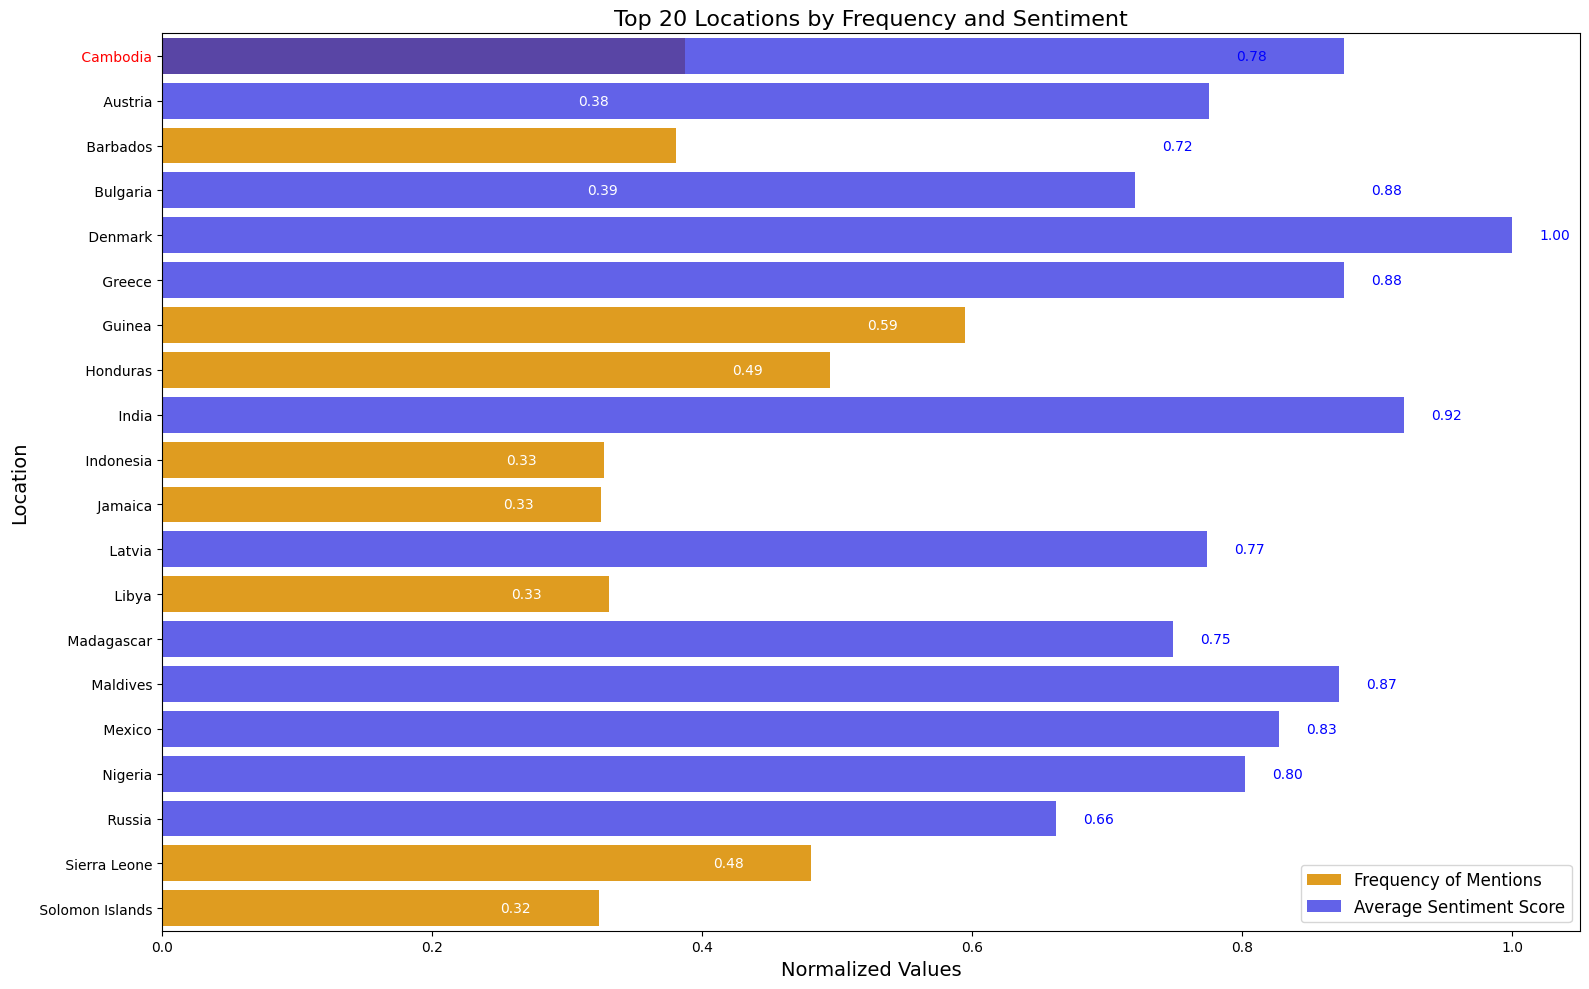

In [ ]:
df_intensity_top20 = df_intensity.nlargest(20, 'Frequency of Mentions')
df_intensity_top20 = df_intensity_top20[df_intensity_top20['Location'] != 'Syria']

df_bias_top20 = df_bias.nlargest(20, 'Average Sentiment Score')
df_bias_top20 = df_bias_top20[df_bias_top20['Location'] != 'Syria']

# Merge the dataframes
merged_df = df_intensity_top20.merge(
    df_bias_top20[['Location', 'Average Sentiment Score']],
    on='Location',
    how='outer'
)

# Normalize the metrics for comparability
merged_df['Normalized Frequency'] = merged_df['Frequency of Mentions'] / merged_df['Frequency of Mentions'].max()
merged_df['Normalized Sentiment'] = merged_df['Average Sentiment Score'] / merged_df['Average Sentiment Score'].max()

# Sort by combined score (optional: adjust weights as needed)
merged_df['Combined Score'] = 0.7 * merged_df['Normalized Frequency'] + 0.3 * merged_df['Normalized Sentiment']
merged_df = merged_df.sort_values('Combined Score', ascending=False)  # Sort from most to least

# Select only the top 20 locations based on the combined score
top_20_df = merged_df.head(20)

# Create a stacked bar chart
plt.figure(figsize=(16, 10))
sns.barplot(
    x='Normalized Frequency',
    y='Location',
    data=top_20_df,
    color='orange',
    label='Frequency of Mentions'
)
sns.barplot(
    x='Normalized Sentiment',
    y='Location',
    data=top_20_df,
    color='blue',
    alpha=0.7,
    label='Average Sentiment Score'
)

# Add data labels
for i, row in top_20_df.iterrows():
    plt.text(row['Normalized Frequency'] - 0.05, i, f"{row['Normalized Frequency']:.2f}",
             color='white', va='center', ha='right', fontsize=10)
    plt.text(row['Normalized Sentiment'] + 0.02, i, f"{row['Normalized Sentiment']:.2f}",
             color='blue', va='center', ha='left', fontsize=10)

# Add labels, title, and legend
plt.xlabel('Normalized Values', fontsize=14)
plt.ylabel('Location', fontsize=14)
plt.title('Top 20 Locations by Frequency and Sentiment', fontsize=16)
plt.legend(loc='lower right', fontsize=12)

# Highlight the top location
plt.gca().get_yticklabels()[0].set_color('red')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import scipy.stats as stats

contingency_table = pd.crosstab(df_intensity['Location Group'], df_intensity['Frequency of Mentions'])

chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Output result
print(f"Chi-squared Stat: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

Chi-squared Stat: 250.0
P-Value: 3.3384971235833434e-05
Degrees of Freedom: 167
Expected Frequencies: 
[[0.496 3.472 1.984 0.992 1.984 1.984 1.984 0.992 1.488 0.496 1.488 0.496
  0.496 1.488 1.984 2.48  0.992 2.48  2.48  0.992 1.488 1.984 2.48  0.992
  0.496 1.984 1.488 1.488 0.992 1.984 2.48  0.992 0.992 0.496 0.496 0.496
  0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.992
  0.496 0.496 0.496 0.496 0.992 0.496 0.496 0.992 0.496 0.496 0.496 0.496
  0.992 1.488 0.496 0.496 0.496 0.496 0.992 0.496 0.496 0.496 0.496 0.496
  0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496
  0.992 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496
  0.496 0.496 0.496 0.496 0.496 0.992 0.496 0.496 0.496 0.496 0.496 0.496
  0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496
  0.496 0.496 0.992 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496 0.496
  0.496 0.496 0.496 0.496 1.488 0.496 0.496 0.496 0.496 0.496 0.496 0.496
  0.496 0

## **Global Sentiment Map with Top Positive and Negative Words**  

#### **Purpose:**  
Display global sentiment scores and highlight top positive and negative words for each country.

#### **Approach:**  
1. **Data Enrichment:** Added top positive/negative words with their sentiment scores for each country.  
2. **Choropleth Creation:** Visualized `Net_Sentiment` using a diverging `RdYlGn` color scale.  
3. **Hover Details:** Enhanced hover tooltips to include sentiment scores and top positive/negative words.  
4. **Map Design:** Styled with neutral land/ocean colors, "natural earth" projection, and clean layout.  
5. **Customization:** Adjusted the title, centered layout, and added a color bar for clarity.  


In [ ]:
import plotly.express as px
def add_top_words_to_df(sentiment_df, sentiment_results):
    top_words_data = []
    for country in sentiment_df['Country']:
        if country in sentiment_results:
            top_positive = ", ".join(
                [f"{word} ({score:.2f})" for word, score in sentiment_results[country]["Top Positive Words"][:3]]
            )
            top_negative = ", ".join(
                [f"{word} ({score:.2f})" for word, score in sentiment_results[country]["Top Negative Words"][:3]]
            )
        else:
            top_positive = "N/A"
            top_negative = "N/A"

        top_words_data.append({
            "Country": country,
            "Top_Positive_x_x": top_positive,
            "Top_Negative_X_x": top_negative
        })

    # Convert to DataFrame and merge with sentiment_df
    top_words_df = pd.DataFrame(top_words_data)
    sentiment_df = sentiment_df.merge(top_words_df, on="Country", how="left")
    return sentiment_df

sentiment_df = add_top_words_to_df(sentiment_df, sentiment_results)

# Create the choropleth map
fig = px.choropleth(
    sentiment_df,
    locations="Country",
    locationmode="country names",
    color="Net_Sentiment",
    color_continuous_scale="RdYlGn",
    title="Global Average Sentiment Score",
    labels={"Net_Sentiment": "Net Sentiment Score"},
)

fig.update_geos(
    showcoastlines=True,
    coastlinecolor="LightGray",
    showland=True,
    landcolor="whitesmoke",
    showocean=True,
    oceancolor="LightBlue",
    showframe=False,
    projection_type="natural earth",
    visible=True,
)

fig.update_traces(
    hovertemplate=(
        "<b>Country:</b> %{location}<br>"
        "<b>Net Sentiment Score:</b> %{z:.2f}<br>"
        "<b>Top Positive Words:</b> %{customdata[0]}<br>"
        "<b>Top Negative Words:</b> %{customdata[1]}<br>"
    ),
    customdata=sentiment_df[['Top_Positive_x_x', 'Top_Negative_X_x']].values
)
fig.update_layout(
    title=dict(
        text="🌍 Global Sentiment Map: Average Sentiment Score by Country",
        font=dict(size=20, family="Arial, sans-serif"),
        x=0.5,
        xanchor="center",
    ),
    coloraxis_colorbar=dict(
        title="Net Sentiment",
        titlefont=dict(size=14),
        tickfont=dict(size=12),
        len=0.6,
    ),
    margin=dict(l=20, r=20, t=50, b=20),
    paper_bgcolor="white",
)

fig.show()

## **Interactive Theme Map with Geolocated Clusters**  

#### **Purpose:**  
To create an interactive visualization of themes distributed across global locations using geospatial clustering. This allows users to explore and identify the dominant themes in various regions, along with associated keywords.

---

#### **Approaches:**

1. **Data Preparation and Cleaning:**  
   - Processed and grouped the dataset by `theme` and `location`.  
   - Extracted theme-specific keywords (`words`) and calculated the most frequent ones.  
   - Flattened keyword lists to ensure proper rendering in the visualization.

2. **Geolocation Mapping:**  
   - Used the `geopy` library to fetch latitude and longitude for countries or locations based on their names.  
   - Assigned marker locations on the map corresponding to geocoded coordinates.  

3. **Theme-Based Marker Customization:**  
   - Defined a color scheme for each theme using a dictionary (`get_theme_color`) for visual clarity.  
   - Incorporated circular markers with radius and color coded by theme for immediate differentiation.  

4. **Interactive Features:**  
   - Pop-ups for each marker display detailed information, including the theme, location, and associated keywords.  
   - Tooltip with a hover effect for quick identification of themes.  

5. **Cluster Visualization:**  
   - Used Folium's `MarkerCluster` to group nearby markers dynamically. This reduces clutter and enhances map usability, particularly in regions with dense data points.  

6. **Custom Legend:**  
   - Added a modern styled, fixed-position legend to explain theme colors using HTML and CSS.  

7. **Map Styling and Aesthetics:**  
   - Chose the `CartoDB Positron` tile style for a clean and minimalistic background.  
   - Customized map elements such as coastline visibility and zoom levels for better user interaction.  

---

This interactive map combines clustering and color-coded themes to provide an intuitive way to explore the distribution of themes worldwide. The additional legend and interactivity make it user-friendly and visually appealing.

In [ ]:
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

# Initialize geolocator
geolocator = Nominatim(user_agent="geo_viz", timeout=10)

# Initialize the map
world_map = folium.Map(location=[20, 0], zoom_start=2, tiles='CartoDB positron')
marker_cluster = MarkerCluster().add_to(world_map)

# Function to assign a color based on themes
def get_theme_color(theme):
    theme_colors = {
        "Family": "#0074D9",       # Blue
        "Love": "#FF69B4",         # Pink
        "War": "#FF6347",          # Red
        "Politics": "#8A2BE2",     # Purple
        "Crime": "#FFA500",        # Orange
        "Nature": "#32CD32",       # Lime Green
        "Religious": "#9400D3",    # Dark Violet
        "Tourism": "#228B22",      # Forest Green
        "Friendship": "#ADD8E6",   # Light Blue
        "History": "#20B2AA",      # Light Sea Green
        "Science": "#FFD700",      # Gold
        "Fantasy": "#4B0082",      # Indigo
        "Recovery": "#DAA520",     # Goldenrod
        "Sex & Nudity": "#FF1493"  # Deep Pink for Sex & Nudity
    }
    return theme_colors.get(theme, "#808080")  # Default color if theme is not found

# Precalculate percentages
df_themes['total_count'] = df_themes.groupby('location')['count'].transform('sum')
df_themes['percentage'] = (df_themes['count'] / df_themes['total_count']) * 100
df_themes['percentage'] = df_themes['percentage'].round(2)

# Group countries by theme
grouped_data = df_themes.groupby('theme')

# Iterate through each theme group
for theme, group in grouped_data:
    for _, row in group.iterrows():
        country = row['location']
        theme_word = row['word']
        percentage = row['percentage']

        try:
            # Get geolocation
            location = geolocator.geocode(country)
            if location:
                # Prepare popup content with percentage
                popup_content = f"""
                <b>{theme}</b><br>
                Theme Word: {theme_word}<br>
                Location: {country}<br>
                Percentage: {percentage}%
                """

                # Add marker to cluster with theme color
                folium.CircleMarker(
                    location=[location.latitude, location.longitude],
                    radius=8,
                    color=get_theme_color(theme),
                    fill=True,
                    fill_color=get_theme_color(theme),
                    fill_opacity=0.8,
                    tooltip=folium.Tooltip(f"{theme}: {percentage}%"),
                    popup=folium.Popup(popup_content, max_width=300),
                    weight=2
                ).add_to(marker_cluster)
        except Exception as e:
            print(f"Error processing country {country}: {e}")

# Add the legend to the map
legend_html = """
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 250px; height: auto;
            background-color: rgba(255, 255, 255, 0.8); z-index: 9999; border:2px solid #aaa;
            padding: 10px; font-size: 14px; font-family: Arial, sans-serif;">
    <b>Theme Legend:</b><br>
    <div><i style="background: #0074D9; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Family</div>
    <div><i style="background: #FF69B4; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Love</div>
    <div><i style="background: #FF6347; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> War</div>
    <div><i style="background: #8A2BE2; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Politics</div>
    <div><i style="background: #FFA500; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Crime</div>
    <div><i style="background: #32CD32; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Nature</div>
    <div><i style="background: #9400D3; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Religious</div>
    <div><i style="background: #228B22; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Tourism</div>
    <div><i style="background: #ADD8E6; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Friendship</div>
    <div><i style="background: #20B2AA; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> History</div>
    <div><i style="background: #FFD700; padding: 5px; color: black; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Science</div>
    <div><i style="background: #4B0082; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Fantasy</div>
    <div><i style="background: #DAA520; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Recovery</div>
    <div><i style="background: #FF1493; padding: 5px; color: white; border-radius: 5px;">&nbsp;&nbsp;&nbsp;</i> Sex & Nudity</div>
</div>
"""

# Add the legend to the map
world_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
world_map.save("themes_map_with_percentages.html")
